In [1]:
import pymysql
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
conn = pymysql.connect(
    host="127.0.0.1",
    user="root",
    password="password",
    database="olist"
)

In [7]:
repurchase_review_sql = """
    WITH total_order AS (
    	SELECT
    		category_name_translation.product_category_name_english AS category_name,
    		orders.customer_id,
    		COUNT(orders.order_id) AS cnt_order
    	FROM
    		orders
    	INNER JOIN
    		order_items
    	ON
    		orders.order_id = order_items.order_id
    	INNER JOIN
    		products
    	ON
    		order_items.product_id = products.product_id
    	INNER JOIN
    		category_name_translation
    	ON
    		products.product_category_name = category_name_translation.product_category_name
    	WHERE
    		orders.order_status = 'delivered'
    	GROUP BY
    		category_name, customer_id
    ),
    category_repurchase AS (
    	SELECT
    		category_name,
    		(SUM(IF (cnt_order > 1, 1, 0)) / COUNT(cnt_order)) * 100 AS repurchase_rate
    	FROM
    		total_order
    	GROUP BY
    		category_name
    ),
    avg_review AS (
    	SELECT
    		category_name_translation.product_category_name_english AS category_name,
    		AVG(reviews.review_score) AS avg_review_score
    	FROM
    		reviews
    	INNER JOIN
    		order_items
    	ON
    		reviews.order_id = order_items.order_id
    	INNER JOIN
    		products
    	ON
    		order_items.product_id = products.product_id
    	INNER JOIN
    		category_name_translation
    	ON
    		products.product_category_name = category_name_translation.product_category_name
    	GROUP BY
    		category_name
    )
    SELECT
    	category_repurchase.category_name,
        avg_review.avg_review_score,
    	category_repurchase.repurchase_rate
    FROM
    	category_repurchase
    INNER JOIN
    	avg_review
    ON
    	category_repurchase.category_name = avg_review.category_name
    ORDER BY
    	avg_review_score DESC;
"""

In [8]:
repurchase_review_df = pd.read_sql(repurchase_review_sql, conn)
repurchase_review_df = repurchase_review_df.set_index("category_name")
repurchase_review_df.to_csv("repurchase_review.csv", header=True)

C:\Users\minni\AppData\Local\Temp\ipykernel_40876\51252261.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  repurchase_review_df = pd.read_sql(repurchase_review_sql, conn)


In [9]:
repurchase_review_df

,avg_review_score,repurchase_rate
category_name,,
cds_dvds_musicals,4.6429,16.6667
fashion_childrens_clothes,4.5000,0.0000
books_general_interest,4.4463,6.2500
costruction_tools_tools,4.4444,6.1856
flowers,4.4194,13.7931
...,...,...
fashion_male_clothing,3.6412,14.1509
home_comfort_2,3.6296,20.8333
office_furniture,3.4932,18.1021


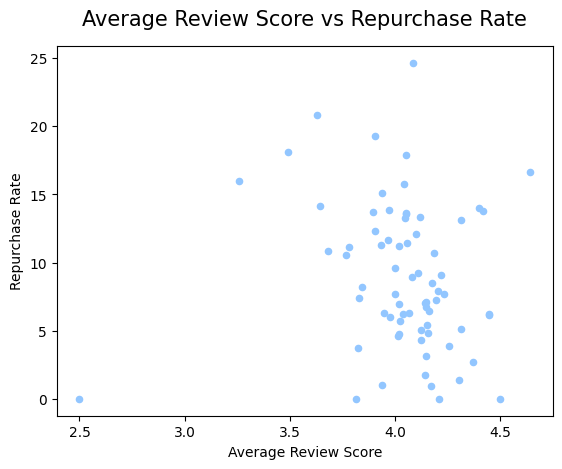

In [11]:
plt.style.use("seaborn-v0_8-pastel")
figure = repurchase_review_df.plot(
    kind="scatter", 
    x="avg_review_score", 
    y="repurchase_rate"
)
figure.set_title("Average Review Score vs Repurchase Rate", size=15, pad=15)
plt.xlabel("Average Review Score")
plt.ylabel("Repurchase Rate")
plt.savefig("repurchase_review.png", bbox_inches='tight')